App_006_001_001_01.ipynb

# Working Code Below

2023-08-30 23:32:06.256 
  command:

    streamlit run /Users/luis/miniforge3/envs/venv_FCC_Build_12_DS_Apps_Python_Streamlit_310/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-08-30 23:32:06.258 No runtime found, using MemoryCacheStorageManager
2023-08-30 23:32:06.259 No runtime found, using MemoryCacheStorageManager


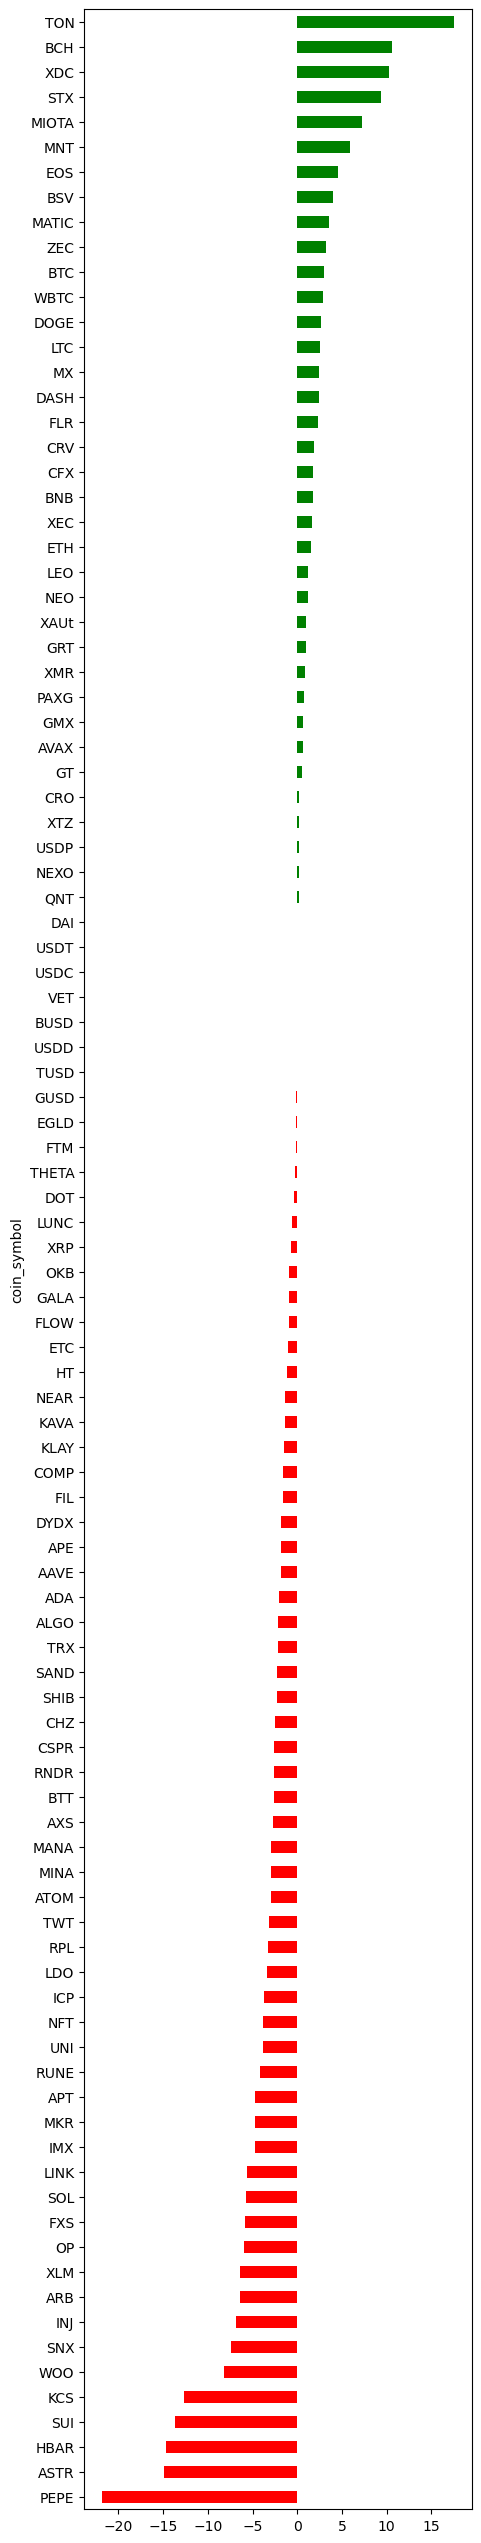

In [1]:
# This app is for educational purpose only. Insights gained is not financial advice. Use at your own risk!
import streamlit as st
from PIL import Image
import pandas as pd
import base64
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import json
import time

# ---------------------------------#
# New feature (make sure to upgrade your streamlit library)
# pip install --upgrade streamlit

# ---------------------------------#
# Page layout
# Page expands to full width
st.set_page_config(layout="wide")
# ---------------------------------#
# Title

#image = Image.open("logo.jpg")
image = Image.open('./Projects/App_006_001/App_006_001_Exported/Data/Images/App_006_001_Resources/pexels-david-mcbee-730547.jpg')

st.image(image, width=500)

st.title("Crypto Price App")
st.markdown(
    """
This app retrieves cryptocurrency prices for the top 100 cryptocurrency from the **CoinMarketCap**!

"""
)
# ---------------------------------#
# About
expander_bar = st.expander("About")
expander_bar.markdown(
    """
* **Data source:** [CoinMarketCap](http://coinmarketcap.com).
* **Credit:** Web scraper adapted from the Medium article *[Web Scraping Crypto Prices With Python](https://towardsdatascience.com/web-scraping-crypto-prices-with-python-41072ea5b5bf)* written by [Bryan Feng](https://medium.com/@bryanf).
"""
)


# ---------------------------------#
# Page layout (continued)
# Divide page to 3 columns (col1 = sidebar, col2 and col3 = page contents)
col1 = st.sidebar
col2, col3 = st.columns((2, 1))

# ---------------------------------#
# Sidebar + Main panel
col1.header("Input Options")

# Sidebar - Currency price unit
currency_price_unit = col1.selectbox("Select currency for price", ("USD", "BTC", "ETH"))

# Web scraping of CoinMarketCap data
@st.cache_data
def load_data():
    cmc = requests.get("https://coinmarketcap.com")
    soup = BeautifulSoup(cmc.content, "html.parser")

    data = soup.find("script", id="__NEXT_DATA__", type="application/json")
    coins = {}
    #coin_data = json.loads(data.contents[0])
    #listings = coin_data["props"]["initialState"]["cryptocurrency"]["listingLatest"][
        #"data"
    #]
    coin_data = json.loads(data.contents[0])# Modified by me
    s = coin_data['props']['initialState']# Modified by me
    listings = json.loads(s.replace("'", ""))# Modified by me it is a string of dictionaries. Get rid of the string to retrieve the dictionary
    listings = listings['cryptocurrency']['listingLatest']['data']# Modified by me
    
    attributes = listings[0]["keysArr"]
    index_of_id = attributes.index("id")
    index_of_slug = attributes.index("slug")

    for i in listings[1:]:
        coins[str(i[index_of_id])] = i[index_of_slug]

    coin_name = []
    coin_symbol = []
    market_cap = []
    percent_change_1h = []
    percent_change_24h = []
    percent_change_7d = []
    price = []
    volume_24h = []

    index_of_slug = attributes.index("slug")
    index_of_symbol = attributes.index("symbol")

    index_of_quote_currency_price = attributes.index(
        f"quote.{currency_price_unit}.price"
    )
    index_of_quote_currency_percent_change_1h = attributes.index(
        f"quote.{currency_price_unit}.percentChange1h"
    )
    index_of_quote_currency_percent_change_24h = attributes.index(
        f"quote.{currency_price_unit}.percentChange24h"
    )
    index_of_quote_currency_percent_change_7d = attributes.index(
        f"quote.{currency_price_unit}.percentChange7d"
    )
    index_of_quote_currency_market_cap = attributes.index(
        f"quote.{currency_price_unit}.marketCap"
    )
    index_of_quote_currency_volume_24h = attributes.index(
        f"quote.{currency_price_unit}.volume24h"
    )

    for i in listings[1:]:
        coin_name.append(i[index_of_slug])
        coin_symbol.append(i[index_of_symbol])

        price.append(i[index_of_quote_currency_price])
        percent_change_1h.append(i[index_of_quote_currency_percent_change_1h])
        percent_change_24h.append(i[index_of_quote_currency_percent_change_24h])
        percent_change_7d.append(i[index_of_quote_currency_percent_change_7d])
        market_cap.append(i[index_of_quote_currency_market_cap])
        volume_24h.append(i[index_of_quote_currency_volume_24h])

    df = pd.DataFrame(
        columns=[
            "coin_name",
            "coin_symbol",
            "market_cap",
            "percent_change_1h",
            "percent_change_24h",
            "percent_change_7d",
            "price",
            "volume_24h",
        ]
    )
    df["coin_name"] = coin_name
    df["coin_symbol"] = coin_symbol
    df["price"] = price
    df["percent_change_1h"] = percent_change_1h
    df["percent_change_24h"] = percent_change_24h
    df["percent_change_7d"] = percent_change_7d
    df["market_cap"] = market_cap
    df["volume_24h"] = volume_24h
    return df


df = load_data()

# Sidebar - Cryptocurrency selections
sorted_coin = sorted(df["coin_symbol"])
selected_coin = col1.multiselect("Cryptocurrency", sorted_coin, sorted_coin)

df_selected_coin = df[(df["coin_symbol"].isin(selected_coin))]  # Filtering data

# Sidebar - Number of coins to display
num_coin = col1.slider("Display Top N Coins", 1, 100, 100)
df_coins = df_selected_coin[:num_coin]

# Sidebar - Percent change timeframe
percent_timeframe = col1.selectbox("Percent change time frame", ["7d", "24h", "1h"])
percent_dict = {
    "7d": "percent_change_7d",
    "24h": "percent_change_24h",
    "1h": "percent_change_1h",
}
selected_percent_timeframe = percent_dict[percent_timeframe]

# Sidebar - Sorting values
sort_values = col1.selectbox("Sort values?", ["Yes", "No"])

col2.subheader("Price Data of Selected Cryptocurrency")
col2.write(
    "Data Dimension: "
    + str(df_selected_coin.shape[0])
    + " rows and "
    + str(df_selected_coin.shape[1])
    + " columns."
)

col2.dataframe(df_coins)

# Download CSV data
# https://discuss.streamlit.io/t/how-to-download-file-in-streamlit/1806
def filedownload(df):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()  # strings <-> bytes conversions
    href = f'<a href="data:file/csv;base64,{b64}" download="crypto.csv">Download CSV File</a>'
    return href


col2.markdown(filedownload(df_selected_coin), unsafe_allow_html=True)

# ---------------------------------#
# Preparing data for Bar plot of % Price change
col2.subheader("Table of % Price Change")
df_change = pd.concat(
    [
        df_coins.coin_symbol,
        df_coins.percent_change_1h,
        df_coins.percent_change_24h,
        df_coins.percent_change_7d,
    ],
    axis=1,
)
df_change = df_change.set_index("coin_symbol")
df_change["positive_percent_change_1h"] = df_change["percent_change_1h"] > 0
df_change["positive_percent_change_24h"] = df_change["percent_change_24h"] > 0
df_change["positive_percent_change_7d"] = df_change["percent_change_7d"] > 0
col2.dataframe(df_change)

# Conditional creation of Bar plot (time frame)
col3.subheader("Bar plot of % Price Change")

if percent_timeframe == "7d":
    if sort_values == "Yes":
        df_change = df_change.sort_values(by=["percent_change_7d"])
    col3.write("*7 days period*")
    plt.figure(figsize=(5, 25))
    plt.subplots_adjust(top=1, bottom=0)
    df_change["percent_change_7d"].plot(
        kind="barh",
        color=df_change.positive_percent_change_7d.map({True: "g", False: "r"}),
    )
    col3.pyplot(plt)
elif percent_timeframe == "24h":
    if sort_values == "Yes":
        df_change = df_change.sort_values(by=["percent_change_24h"])
    col3.write("*24 hour period*")
    plt.figure(figsize=(5, 25))
    plt.subplots_adjust(top=1, bottom=0)
    df_change["percent_change_24h"].plot(
        kind="barh",
        color=df_change.positive_percent_change_24h.map({True: "g", False: "r"}),
    )
    col3.pyplot(plt)
else:
    if sort_values == "Yes":
        df_change = df_change.sort_values(by=["percent_change_1h"])
    col3.write("*1 hour period*")
    plt.figure(figsize=(5, 25))
    plt.subplots_adjust(top=1, bottom=0)
    df_change["percent_change_1h"].plot(
        kind="barh",
        color=df_change.positive_percent_change_1h.map({True: "g", False: "r"}),
    )
    col3.pyplot(plt)